In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import mne
import csv
from mne.io import read_raw_fif, read_raw_ctf, read_raw_bti, read_raw_kit
from mne.datasets import sample, spm_face, testing
from mne.viz import plot_alignment
from sklearn.svm import SVC  # noqa
from sklearn.cross_validation import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from mne.decoding import TimeDecoding, GeneralizationAcrossTime
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import time
import h5py
import scipy
import random
from PIL import Image
from scipy import ndimage

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import mne
from mne.io import read_raw_ctf

In [2]:
def load_data(path):
    data_path=path
    data=mne.io.read_raw_ctf(data_path , preload=True)
    sampling_rate = data.info['sfreq']
    return data , sampling_rate

In [3]:
def markers(path, sampling_rate):
    marker = []
    with open(path, 'r') as file: 
        a= file.readline()
        while a != "":
             a= file.readline()
             if any(c in u'+' for c in a):
                     q=a.split()
                     marker.append(int(float(q[1])*sampling_rate))
    return marker

In [4]:
def random_markers(window_size, sampling_rate, marker):
    random_marker = []
    buffer = window_size*sampling_rate
    if len(marker) <= 0:
        return random_marker
    for i in range(len(marker)):
        if i == 0 and marker[0] > buffer:
            random_marker.append(random.randint(buffer,marker[0]))
        else:
            random_marker.append(random.randint(marker[i-1]+buffer,marker[i]-buffer))
    random_marker.append(random.randint(marker[i]+buffer, 72000-buffer))
    return random_marker

In [5]:
def preprocessing(raw):
    picks = mne.pick_types(raw.info, meg='mag', eeg=False, stim=False, exclude='bads')
    raw.filter(3, 70, picks=picks,l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_design='firwin')
    channels = ['BG1-2511', 'BG2-2511', 'BG3-2511', 'BP1-2511', 'BP2-2511', 'BP3-2511', 'BQ1-2511', 'BQ2-2511', 'BQ3-2511', 'BR1-2511', 'BR2-2511', 'BR3-2511', 'G12-2511', 'G13-2511', 'G23-2511', 'P12-2511', 'P13-2511', 'Q12-2511', 'Q13-2511', 'Q21-2511', 'Q23-2511', 'R12-2511', 'R13-2511', 'R23-2511', 'SCLK01-177', 'G11-2511', 'G22-2511', 'P11-2511', 'P22-2511', 'Q11-2511', 'Q22-2511', 'R11-2511', 'R22-2511', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'EEG020', 'EEG021', 'EKG']
    raw = raw.drop_channels(channels)
    return raw

In [6]:
def addchannel(raw):
    info = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
    stim_data = np.zeros((1, len(raw.times)))
    stim_raw = mne.io.RawArray(stim_data, info)
    raw.add_channels([stim_raw], force_update_info=True)
    return raw

In [7]:
# window size (s)
window_size = 0.2

In [13]:
windows=[]
target=[]

ds_name='anonepi_09.ds'
file_path = os.path.join(os.getcwd(), '..', 'data/'+ds_name)
data, sampling_rate=load_data(file_path)
data_preprocessed = preprocessing(data)

# add stimulus channel
data_sti = addchannel(data_preprocessed)
marker_epi = markers(file_path+'/MarkerFile.mrk' , sampling_rate)
marker_non = random_markers(window_size, sampling_rate, marker_epi)
event_1 = marker_epi + marker_non
event_2 = [0] * (len(marker_epi)+len(marker_non))
event_3 = [8] * len(marker_epi) + [9] * len(marker_non)
events = np.array([event_1, event_2, event_3]).T
data_sti.add_events(events, stim_channel='STI')

ds directory : /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_09.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.59   79.40    0.00 mm <->    0.59   79.40    0.00 mm (orig :  -49.13   63.21 -268.88 mm) diff =    0.000 mm
      -0.59  -79.40   -0.00 mm <->   -0.59  -79.40   -0.00 mm (orig :   59.30  -52.80 -268.96 mm) diff =    0.000 mm
     104.68   -0.00    0.00 mm <->  104.68    0.00    0.00 mm (orig :   75.41   71.97 -229.50 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 21 EEG channels from channel info
    21 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_09.ds/anonepi_09.meg4: 
    System clock channel is available, checking which sample

In [76]:
find_event_train = mne.find_events(data_sti, stim_channel='STI')
print(find_event_train)

11 events found
Events id: [8 9]
[[ 2590     0     9]
 [ 4065     0     8]
 [ 9830     0     9]
 [11299     0     8]
 [11807     0     9]
 [12999     0     8]
 [15927     0     9]
 [26818     0     8]
 [47096     0     9]
 [61630     0     8]
 [63928     0     9]]


In [79]:
def compute_epochs_events(data_sti, raw, trial_name):
    events = mne.find_events(data_sti, stim_channel='STI')
    # Events:
    # 9 - non-epi window
    # 8 - epi window
    # picks = mne.pick_types(data.info, meg='grad', eeg=False, stim=False, eog=False, exclude='bads')
    picks = mne.pick_types(raw.info, meg='mag', eeg=False, stim=False, eog=False, exclude='bads')
    event_id = dict(positive=8, negative=9)
    tmin = -0.1  # start of each epoch (500ms before the trigger)
    tmax = 0.1  # end of each epoch (500ms after the trigger)
    epochs = mne.Epochs(data_sti, events, event_id, tmin, tmax, proj=False, picks=picks, baseline=None, preload=True)
    epochs_proj = mne.Epochs(data_sti, events, None, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
    labels = epochs.events[:, -1]
    
    # output epochs/labels info
    print(epochs)
    #epochs.plot()
    #epochs.plot_psd(fmin=2., fmax=500)
    print(epochs.get_data().shape)
    # print(epochs.get_data())
    print(labels)

    # evoked without ssp
#     evoked = epochs.average()
#     print(evoked)
#     evoked.plot()

    epochs.save(trial_name+'epochs-epo.fif')
    return epochs, labels

In [80]:
epochs, labels = compute_epochs_events(data_sti, data, 'epoch-09-')

11 events found
Events id: [8 9]
11 matching events found
Loading data for 11 events and 121 original time points ...
0 bad epochs dropped
11 matching events found
0 projection items activated
Loading data for 11 events and 121 original time points ...
0 bad epochs dropped
<Epochs  |  n_events : 11 (all good), tmin : -0.1 (s), tmax : 0.1 (s), baseline : None, ~2.1 MB, data loaded,
 'negative': 6, 'positive': 5>
(11, 151, 121)
[9 8 9 8 9 8 9 8 9 8 9]


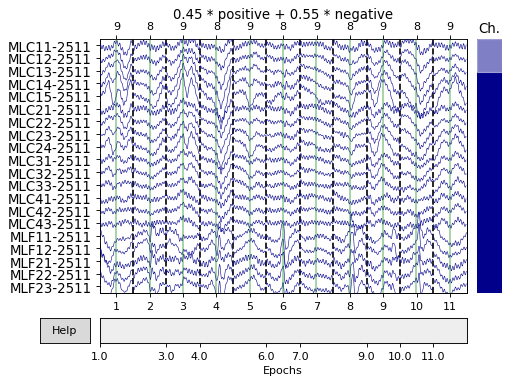

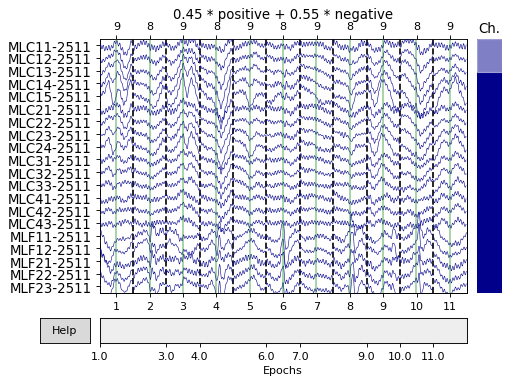

In [82]:
epochs.plot(picks=None, scalings=None, n_epochs=20, n_channels=20, title=None, events=None, event_colors=None, show=True, block=False, decim='auto')